In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from TP4b.metrics import fi_perm
from dnn_tau import Dnn_tau
from data_extractor import Data_extractor_v2, output_vars_v2
import os
import fnmatch
from utils import normalize, bucketize, split_dataset
from copy import deepcopy
import pickle
from TP4b.metrics import *
import matplotlib.pyplot as plt

## Selection of features

In [6]:
import pickle
ratio = 1/100

channels = ['tee', 'tem', 'tmm', 'tte', 'ttm']
selected_vars = []

for channel in channels:
    with open('saved_results/TEST9_global_v4_loss_shuffle_all_channels_eval_'+channel, 'rb') as file:
        fi = pickle.load(file)
    sorted_fi = sorted(fi.items(), key=lambda x: x[1], reverse=True)
    names = [item[0] for item in sorted_fi]
    values = [item[1][0] for item in sorted_fi]

    threshold = max(values[1:])*ratio

    sel_values = [v for v in values if v > threshold]
    sel_names = names[:len(sel_values)]

    selected_vars.extend(sel_names)
    print(sel_names)

selected_vars = list(set(selected_vars))
print(selected_vars)
print(len(selected_vars))

filename = "saved_results/selected_vars_threshold_100"
with open(filename, "wb") as file:
    pickle.dump(selected_vars, file)

['mass_hyp', 'HNL_CM_mass_1', 'Mt_tot', 'HNL_CM_mass_2', 'mass_23', 'pt_123', 'mt_1MET', 'mass_123', 'pt_MET', 'HNL_CM_mass_with_MET_1', 'pt_1', 'mt_12', 'mt_2MET', 'HNL_CM_mass_with_MET_2', 'mt_13', 'mass_13', 'mt_1(3MET)', 'mt_3MET', 'pt_2', 'mt_23', 'mt_MET(13)', 'mt_2(1MET)', 'mass_12', 'mt_2(13)', 'mt_3(2MET)']
['mass_hyp', 'HNL_CM_mass_1', 'Mt_tot', 'HNL_CM_mass_2', 'mass_23', 'mt_1MET', 'pt_123', 'mass_123', 'mt_2MET', 'pt_MET', 'mt_3MET', 'HNL_CM_mass_with_MET_1', 'pt_1', 'mt_12', 'HNL_CM_mass_with_MET_2', 'mass_13', 'mt_13', 'mt_23', 'mt_1(3MET)', 'mass_12', 'mt_2(1MET)', 'mt_2(13)', 'mt_MET(13)', 'mt_MET(23)', 'mt_1(23)']
['mass_hyp', 'HNL_CM_mass_1', 'Mt_tot', 'HNL_CM_mass_2', 'pt_123', 'mass_23', 'mt_1MET', 'mass_123', 'pt_MET', 'mt_2MET', 'HNL_CM_mass_with_MET_1', 'pt_1', 'mt_12', 'mt_13', 'HNL_CM_mass_with_MET_2', 'mt_1(3MET)', 'mass_12', 'mt_23', 'mass_13', 'mt_MET(13)', 'mt_1(2MET)', 'mt_MET(23)', 'mt_2(13)', 'mt_2(1MET)', 'mt_1(23)', 'pt_2']
['mass_hyp', 'HNL_CM_mass_1

In [2]:
import pickle
import pandas as pd

channels = ['tee', 'tem', 'tmm', 'tte', 'ttm']
filename = "saved_results/selected_vars_threshold_100"
name = "TEST9_global_v4_loss_shuffle_all_channels_eval_"
# name = "TEST9_sel1_test_loss_shuffle_"

with open(filename, "rb") as file:
    selected_vars = pickle.load(file)

fi_dict = {}

for channel in channels:
    with open('saved_results/'+name+channel, 'rb') as file:
        fi = pickle.load(file)
    fi = {key: value[0] for key, value in fi.items()}
    print(fi)
    fi_dict[channel] = {key: fi[key] for key in selected_vars if key in fi}
    
sums = []
for i in range(len(fi_dict[channels[0]])):
    sums.append(0)
sum_of_fi = dict(zip(fi_dict[channels[0]].keys(),sums))
for key in fi_dict['tee']:
    for channel in channels:
        sum_of_fi[key] += fi_dict[channel][key]
    
    for channel in channels:
        fi_dict[channel] = dict(sorted(fi_dict[channel].items(), key=lambda x: sum_of_fi[x[0]], reverse=True))

fi_df = pd.DataFrame(fi_dict)

{'charge_1': -6.698071956634521e-05, 'charge_2': 0.00010637938976287842, 'charge_3': 8.203089237213135e-05, 'pt_1': 0.009707719087600708, 'pt_2': 0.003834769129753113, 'pt_3': 0.00042723119258880615, 'pt_MET': 0.012669682502746582, 'eta_1': -1.6361474990844727e-05, 'eta_2': -1.2412667274475098e-05, 'eta_3': -6.452202796936035e-06, 'mass_1': 6.209313869476318e-05, 'mass_2': 8.982419967651367e-05, 'mass_3': -2.4899840354919434e-05, 'deltaphi_12': 0.00039805471897125244, 'deltaphi_13': 0.0004438161849975586, 'deltaphi_23': 0.00035881996154785156, 'deltaphi_1MET': 0.0002031177282333374, 'deltaphi_2MET': 0.00013266503810882568, 'deltaphi_3MET': 0.00021602213382720947, 'deltaphi_1(23)': 0.00046806037425994873, 'deltaphi_2(13)': 0.0005661696195602417, 'deltaphi_3(12)': 0.0003622770309448242, 'deltaphi_MET(12)': 3.0115246772766113e-05, 'deltaphi_MET(13)': 0.0002219080924987793, 'deltaphi_MET(23)': 0.0004972964525222778, 'deltaphi_1(2MET)': 0.00026063621044158936, 'deltaphi_1(3MET)': 0.00016412

In [3]:
for key in fi_df:
    fi_df[key] /= max(fi_df[key])

In [4]:
feature_labels = [r"$m_T(l_1,l_2+MET)$", r'$m_T(l_3,l_2+MET)$', r'$p_T(l_2)$', r'$m_T(l_1,l_2+l_3)$', r'$m_T(MET,l_1+l_3)$', r'$m_T(MET,l_2+l_3)$', r'$m_T(l_2,l_1+l_3)$', r'$m_T(l_2,l_1+MET)$', r'$m_T(l_1,l_3+MET)$', r'$m(l_1+l_2)$', r'$m_T(l_2,l_3)$', r'$m(l_1+l_3)$', r'$m_T(l_3,MET)$', r'$m_T(l_1,l_3)$', r'$m_{HNL,2}$', r'$m_T(l_1,l_2)$', r'$m_{HNL,1}$', r'$p_T(l_1)$', r'$m_T(l_2,MET)$', r'$p_T(MET)$', r'$m(l_1+l_2+l_3)$', r'$m_T(l_1,MET)$', r'$\sum_{i}p_T(l_i)$', r'$m(l_2+l_3)$', r'$\tilde{m}_{HNL,2}$', r'$M_T^{total}$', r'$\tilde{m}_{HNL,1}$', r'$m_{HNL}^{hyp}$']
feature_labels.reverse()

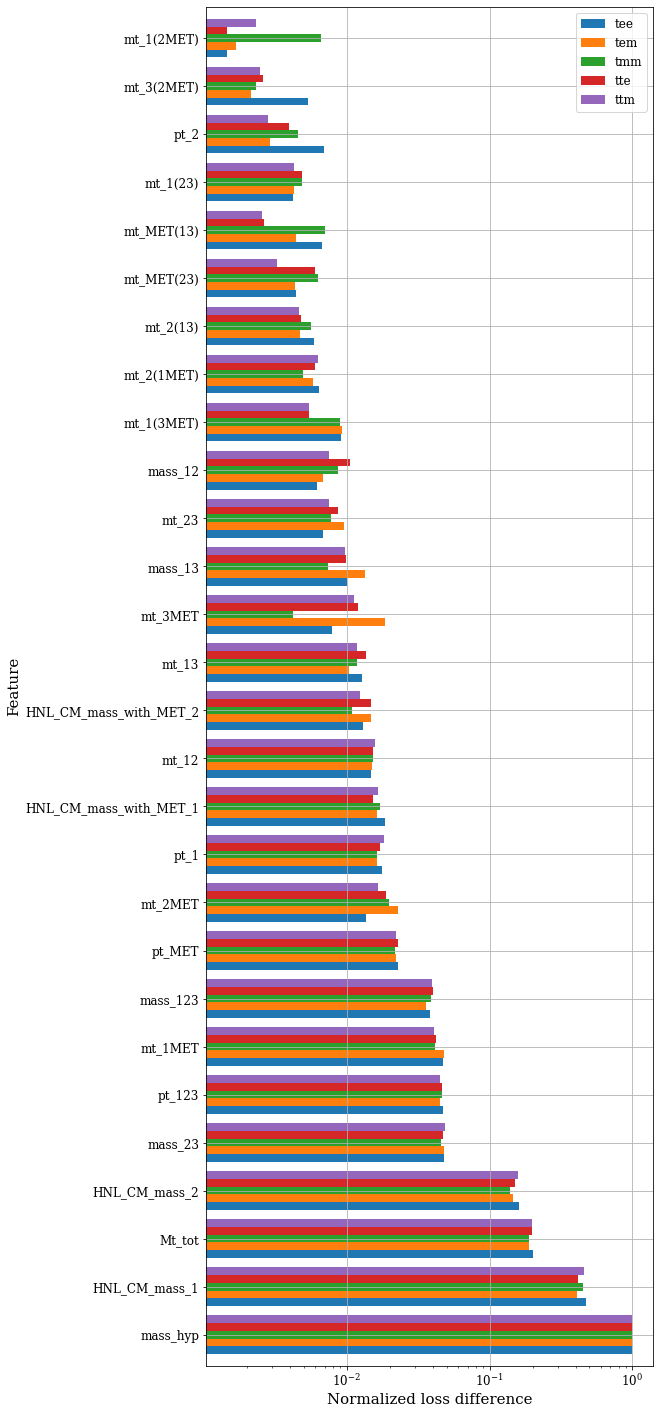

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({"font.size": 16, "font.family": "serif"})

fig, ax = plt.subplots(figsize=(8, 25))
fi_df.plot.barh(ax=ax, width=0.8)
ax.set_xlabel('Normalized loss difference', fontsize=15)
ax.set_ylabel('Feature', fontsize=15)
# ax.set_yticklabels(feature_labels, fontfamily='serif')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)
ax.set_xscale('log')
ax.grid()

# fig.savefig("Images/TEST9_global_v4_fi.pdf")
# fig.savefig("Images/TEST9_sel1_fi.pdf")